In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [2]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        x=self.hidden(x)
        x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

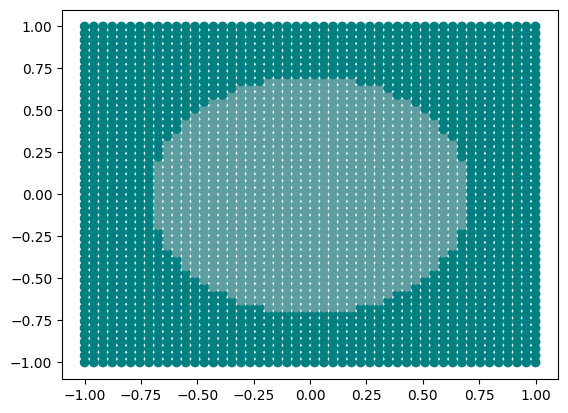

In [3]:
RES=50
X=[]
for x_1 in np.linspace(-1,1,RES):
    for x_2 in np.linspace(-1,1,RES):
        X.append([x_1,x_2])
X=np.array(X)

encode_inputs=lambda x: 1 if x[0]**2+x[1]**2<0.5 else 0
Y=np.array([encode_inputs(x) for x in X])

X=torch.from_numpy(X).float()
Y=torch.from_numpy(Y).float()


colors=np.full(len(Y), 'cadetblue')
colors[Y==0]='teal'

plt.scatter(X[:,0],X[:,1],c=colors)

In [4]:
model = NeuralNet(2,256,2)
ReLU_glorot_init(model)

def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

BATCH_SIZE = 100
EPOCHS = 200
LR = 0.01

opt = SGD(model.parameters(), lr=LR)
lossFunc = nn.CrossEntropyLoss()

In [5]:
def training():
	trainLoss = 0
	samples = 0
	model.train()
	for batchX, batchY in next_batch(X, Y, BATCH_SIZE):
		predictions = model(batchX)
		loss = lossFunc(predictions, batchY.long())
		opt.zero_grad()
		loss.backward()
		opt.step()
		samples += len(batchY)
		trainLoss += loss.item()*len(batchY)
	return trainLoss/samples

In [6]:
for n in range(EPOCHS):
    l=training()
    print('Epoch {}: Loss {:.3f}'.format(n+1,l))

grads_input_layer=[]
grads_hidden_layer=[]
grads_output_layer=[]
for x,y in zip(X,Y):
    predictions = model(x)
    loss = lossFunc(predictions, y.long())
    opt.zero_grad()
    loss.backward()
    gradient_input_layer=[]
    gradient_hidden_layer=[]
    gradient_output_layer=[]
    gradient_input_layer+=torch.flatten(model.input_layer.weight.grad).tolist()
    gradient_input_layer+=model.input_layer.bias.grad.tolist()
    gradient_hidden_layer+=torch.flatten(model.hidden.weight.grad).tolist()
    gradient_hidden_layer+=model.hidden.bias.grad.tolist()
    gradient_output_layer+=torch.flatten(model.output_layer.weight.grad).tolist()
    gradient_output_layer+=model.output_layer.bias.grad.tolist()

    gradient_input_layer=np.array(gradient_input_layer)
    gradient_input_layer=gradient_input_layer/np.linalg.norm(gradient_input_layer)

    gradient_hidden_layer=np.array(gradient_hidden_layer)
    gradient_hidden_layer=gradient_hidden_layer/np.linalg.norm(gradient_hidden_layer)

    gradient_output_layer=np.array(gradient_output_layer)
    gradient_output_layer=gradient_output_layer/np.linalg.norm(gradient_output_layer)

    grads_input_layer.append(gradient_input_layer)
    grads_hidden_layer.append(gradient_hidden_layer)
    grads_output_layer.append(gradient_output_layer)

dot_matrix_input_layer=[]
for i,x1 in enumerate(X):
    avg_dot=0
    samples=0
    for j,x2 in enumerate(X):
        if np.linalg.norm(x1-x2)<0.05 and i!=j:        
            avg_dot+=np.dot(grads_input_layer[i],grads_input_layer[j])
            samples+=1
    avg_dot=avg_dot/samples
    dot_matrix_input_layer.append(avg_dot)

dot_matrix_hidden_layer=[]
for i,x1 in enumerate(X):
    avg_dot=0
    samples=0
    for j,x2 in enumerate(X):
        if np.linalg.norm(x1-x2)<0.05 and i!=j:        
            avg_dot+=np.dot(grads_hidden_layer[i],grads_hidden_layer[j])
            samples+=1
    avg_dot=avg_dot/samples
    dot_matrix_hidden_layer.append(avg_dot)

dot_matrix_output_layer=[]
for i,x1 in enumerate(X):
    avg_dot=0
    samples=0
    for j,x2 in enumerate(X):
        if np.linalg.norm(x1-x2)<0.05 and i!=j:        
            avg_dot+=np.dot(grads_output_layer[i],grads_output_layer[j])
            samples+=1
    avg_dot=avg_dot/samples
    dot_matrix_output_layer.append(avg_dot)

Epoch 1: Loss 0.671
Epoch 2: Loss 0.652
Epoch 3: Loss 0.640
Epoch 4: Loss 0.630
Epoch 5: Loss 0.623
Epoch 6: Loss 0.617
Epoch 7: Loss 0.612
Epoch 8: Loss 0.607
Epoch 9: Loss 0.602
Epoch 10: Loss 0.597
Epoch 11: Loss 0.592
Epoch 12: Loss 0.588
Epoch 13: Loss 0.583
Epoch 14: Loss 0.579
Epoch 15: Loss 0.574
Epoch 16: Loss 0.570
Epoch 17: Loss 0.565
Epoch 18: Loss 0.561
Epoch 19: Loss 0.556
Epoch 20: Loss 0.551
Epoch 21: Loss 0.546
Epoch 22: Loss 0.542
Epoch 23: Loss 0.537
Epoch 24: Loss 0.532
Epoch 25: Loss 0.526
Epoch 26: Loss 0.521
Epoch 27: Loss 0.516
Epoch 28: Loss 0.511
Epoch 29: Loss 0.506
Epoch 30: Loss 0.500
Epoch 31: Loss 0.495
Epoch 32: Loss 0.489
Epoch 33: Loss 0.484
Epoch 34: Loss 0.478
Epoch 35: Loss 0.473
Epoch 36: Loss 0.468
Epoch 37: Loss 0.462
Epoch 38: Loss 0.457
Epoch 39: Loss 0.451
Epoch 40: Loss 0.446
Epoch 41: Loss 0.440
Epoch 42: Loss 0.435
Epoch 43: Loss 0.429
Epoch 44: Loss 0.424
Epoch 45: Loss 0.418
Epoch 46: Loss 0.413
Epoch 47: Loss 0.408
Epoch 48: Loss 0.402
E

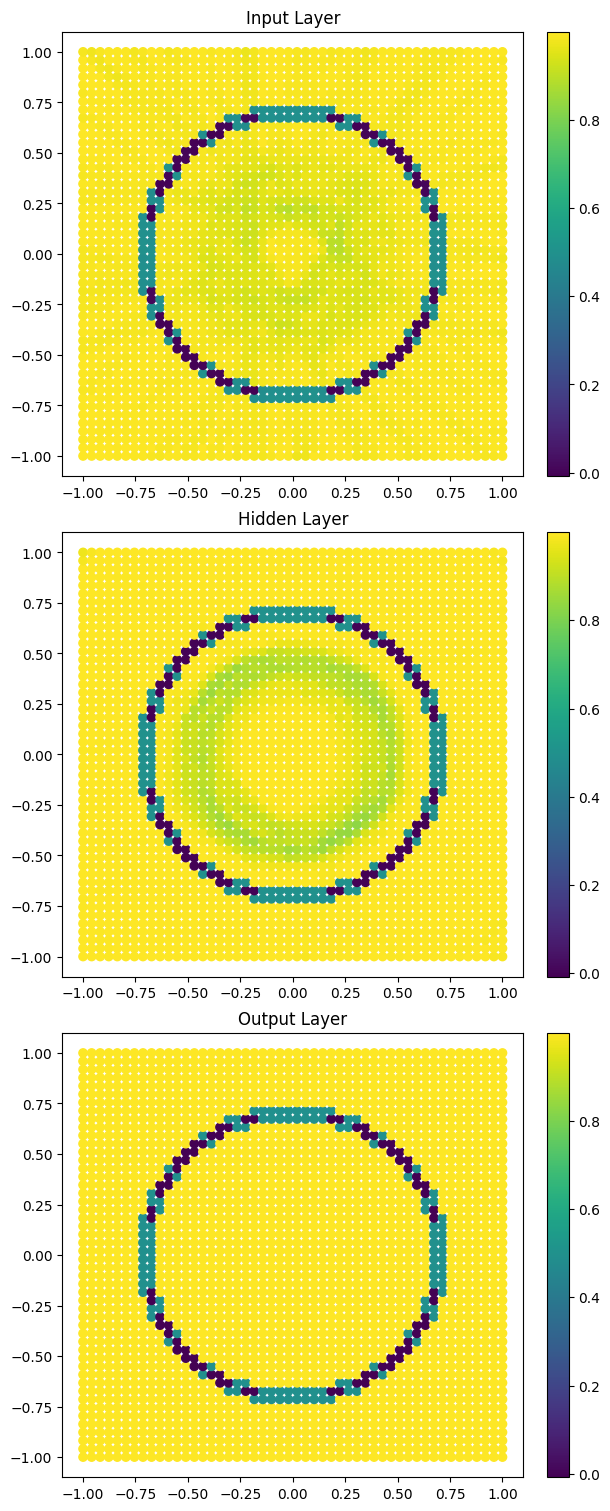

In [11]:
fig, axs = plt.subplots(3,1,figsize=(6,15),layout='constrained')

pcm1 = axs[0].scatter(X[:,0], X[:,1],c=dot_matrix_input_layer)
axs[0].set_title('Input Layer')

fig.colorbar(pcm1, ax=axs[0])

pcm2 = axs[1].scatter(X[:,0], X[:,1],c=dot_matrix_hidden_layer)
axs[1].set_title('Hidden Layer')

fig.colorbar(pcm1, ax=axs[1])

pcm3 = axs[2].scatter(X[:,0], X[:,1],c=dot_matrix_output_layer)
axs[2].set_title('Output Layer')

fig.colorbar(pcm1, ax=axs[2])